In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import lognorm, truncnorm, triang
import gc
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [7]:
# Read Excel file with all sheets
file_path = 'carcinogenic_monte_carlo_dataset.xlsx'
fuchka_data = pd.read_excel(file_path, sheet_name='Metal_Concentration_Fuchka', skiprows=1)
tamarind_data = pd.read_excel(file_path, sheet_name='Metal_Concentration_Tamarind', skiprows=1)

print("Data loaded successfully!")
print(f"Fuchka samples: {len(fuchka_data)}")
print(f"Tamarind samples: {len(tamarind_data)}")

Data loaded successfully!
Fuchka samples: 42
Tamarind samples: 42


In [8]:
# Define parameters for ILCR calculation
parameters = {
    'adult': {
        'ed': 70, 'efr': 365, 'fir_fuchka': 0.1, 'fir_tamarind': 0.03, 
        'bw': 70, 'at': 70 * 365
    },
    'child': {
        'ed': 6, 'efr': 365, 'fir_fuchka': 0.1, 'fir_tamarind': 0.03, 
        'bw': 24, 'at': 6 * 365
    }
}

In [9]:
# Cancer Slope Factors (CSF) - (µg/kg/day)⁻¹
csf_values = {
    'As': 0.0015, 'Ni': 0.00091, 'Cd': 0.0063, 'Pb': 0.0085, 'Cr': 0.00042
}

In [10]:
def run_optimized_monte_carlo(metal, age_group, n_iterations=10000):
    """Optimized Monte Carlo simulation for single metal-age combination"""
    
    print(f"Processing {metal} - {age_group}...")
    
    # Get parameters
    params = parameters[age_group]
    csf = csf_values[metal]
    
    # Pre-generate all random samples
    if age_group == 'adult':
        bw_samples = truncnorm.rvs((45-70)/15, (100-70)/15, loc=70, scale=15, size=n_iterations)
    else:
        bw_samples = truncnorm.rvs((20-24)/5, (50-24)/5, loc=24, scale=5, size=n_iterations)
    
    fir_fuchka_samples = triang.rvs(c=0.5, loc=0.05, scale=0.1, size=n_iterations)
    fir_tamarind_samples = triang.rvs(c=0.5, loc=0.01, scale=0.04, size=n_iterations)
    
    # Storage for results
    all_ilcr = []
    
    # Process samples in smaller batches to save memory
    batch_size = 5  # Process 5 samples at a time
    n_samples = min(len(fuchka_data), len(tamarind_data))
    
    for batch_start in range(0, n_samples, batch_size):
        batch_end = min(batch_start + batch_size, n_samples)
        batch_results = []
        
        for sample_idx in range(batch_start, batch_end):
            # Get metal concentrations
            metal_conc_fuchka = 0
            if metal in fuchka_data.columns:
                metal_conc_fuchka = fuchka_data.iloc[sample_idx][metal]
                metal_conc_fuchka = max(metal_conc_fuchka, 0)  # Ensure non-negative
            
            metal_conc_tamarind = 0
            if metal in tamarind_data.columns:
                metal_conc_tamarind = tamarind_data.iloc[sample_idx][metal] 
                metal_conc_tamarind = max(metal_conc_tamarind, 0)  # Ensure non-negative
            
            # Skip if both concentrations are zero
            if metal_conc_fuchka == 0 and metal_conc_tamarind == 0:
                continue
                
            # Generate varied concentrations with lognormal distribution
            if metal_conc_fuchka > 0:
                fuchka_varied = lognorm.rvs(s=0.5, scale=metal_conc_fuchka, size=n_iterations)
            else:
                fuchka_varied = np.zeros(n_iterations)
                
            if metal_conc_tamarind > 0:
                tamarind_varied = lognorm.rvs(s=0.5, scale=metal_conc_tamarind, size=n_iterations)
            else:
                tamarind_varied = np.zeros(n_iterations)
            
            # Vectorized ILCR calculation
            ilcr_fuchka = (fuchka_varied * fir_fuchka_samples * params['efr'] * params['ed']) / (bw_samples * params['at']) * csf
            ilcr_tamarind = (tamarind_varied * fir_tamarind_samples * params['efr'] * params['ed']) / (bw_samples * params['at']) * csf
            
            # Combined ILCR
            combined_ilcr = ilcr_fuchka + ilcr_tamarind
            batch_results.extend(combined_ilcr.tolist())
        
        all_ilcr.extend(batch_results)
        
        # Clear memory
        del batch_results
        gc.collect()
    
    return np.array(all_ilcr)

In [11]:
def create_optimized_visualization(ilcr_values, metal, age_group, save_path=None):
    """Create optimized cancer risk visualization"""
    
    # Remove zero and very small values
    ilcr_positive = ilcr_values[ilcr_values > 1e-12]
    
    if len(ilcr_positive) == 0:
        print(f"No positive ILCR values for {metal}_{age_group}")
        return
    
    # Sample data if too large (for memory efficiency)
    if len(ilcr_positive) > 50000:
        ilcr_positive = np.random.choice(ilcr_positive, 50000, replace=False)
    
    # Close any existing plots to prevent memory issues
    plt.close('all')
    
    # Create figure with controlled size and DPI
    fig, ax1 = plt.subplots(figsize=(8, 5), dpi=100)
    
    # Create optimized histogram with controlled bins
    n_bins = min(25, int(np.sqrt(len(ilcr_positive))))  # Adaptive bin number
    counts, bins = np.histogram(ilcr_positive, bins=n_bins)
    bin_width = bins[1] - bins[0]
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate proper probability density with bounds checking
    total_area = np.sum(counts) * bin_width
    if total_area > 0:
        probability_density = counts / total_area
        # Ensure probability density is reasonable
        probability_density = np.clip(probability_density, 0, 10)  # Cap at 10
    else:
        probability_density = counts * 0  # All zeros if no area
    
    # Create bar plot with controlled dimensions
    bars = ax1.bar(bin_centers, probability_density, width=bin_width * 0.7, 
                   alpha=0.7, color='red', edgecolor='darkred', 
                   linewidth=0.3, label='Simulated Data')
    
    # Fit and plot lognormal distribution with error handling
    try:
        s, loc, scale = lognorm.fit(ilcr_positive, floc=0)
        
        # Extended range to show complete lognormal curve
        data_min, data_max = ilcr_positive.min(), ilcr_positive.max()
        data_range = data_max - data_min
        
        # Extend range to show full curve tails (start from near zero to well beyond max)
        x_start = max(data_min * 0.01, 1e-10)  # Start from very small positive value
        x_end = data_max * 5  # Extend well beyond data range
        
        x_fit = np.linspace(x_start, x_end, 500)  # More points for smooth curve
        y_fit = lognorm.pdf(x_fit, s, loc, scale)
        
        # Clip y_fit to reasonable values
        y_fit = np.clip(y_fit, 0, 10)
        ax1.plot(x_fit, y_fit, 'g-', linewidth=2, label='Lognormal Fit')
        
        # Store extended range for axis limits
        extended_x_range = (x_start, x_end)
        
    except Exception as e:
        print(f"Could not fit lognormal for {metal}_{age_group}: {e}")
        # Fallback range if fitting fails
        extended_x_range = (ilcr_positive.min() * 0.1, ilcr_positive.max() * 3)
    
    # Calculate statistics
    percentiles = {
        '5th': np.percentile(ilcr_positive, 5),
        '50th': np.percentile(ilcr_positive, 50),  
        '75th': np.percentile(ilcr_positive, 75),
        '95th': np.percentile(ilcr_positive, 95)
    }
    mean_val = np.mean(ilcr_positive)
    
    # Set proper Y-axis limits BEFORE adding lines
    max_prob_density = max(probability_density) if len(probability_density) > 0 else 1
    y_limit = min(max_prob_density * 1.2, 1.0)  # Cap at 1.0 for probability density
    ax1.set_ylim([0, y_limit])
    
    # Add vertical lines with controlled positioning
    colors = {'5th': 'blue', '50th': 'orange', '75th': 'purple', '95th': 'brown'}
    
    # Get extended axis limits to show full lognormal curve
    if 'extended_x_range' in locals():
        ax1.set_xlim(extended_x_range)
    else:
        # Fallback: extend beyond data range
        data_min, data_max = ilcr_positive.min(), ilcr_positive.max()
        ax1.set_xlim([data_min * 0.1, data_max * 3])
    
    # Get current axis limits after setting extended range
    x_min, x_max = ax1.get_xlim()
    y_max = ax1.get_ylim()[1]
    
    for i, (label, value) in enumerate(percentiles.items()):
        # Plot all vertical lines (they should all be within the data range)
        ax1.axvline(value, color=colors[label], linestyle='--', linewidth=1.5, alpha=0.8)
        # Position text labels carefully
        text_y = y_max * (0.9 - i*0.15)
        ax1.text(value, text_y, f'{label}\n{value:.1e}', 
                ha='center', va='top', fontsize=7, rotation=0,
                bbox=dict(boxstyle="round,pad=0.2", facecolor=colors[label], alpha=0.4))
    
    # Add mean line
    ax1.axvline(mean_val, color='black', linestyle='-', linewidth=2, alpha=0.8)
    ax1.text(mean_val, y_max * 0.4, f'Mean\n{mean_val:.1e}', 
            ha='center', va='center', fontsize=7,
            bbox=dict(boxstyle="round,pad=0.2", facecolor='gray', alpha=0.4))
    
    # Set labels and title with controlled font sizes
    ax1.set_xlabel('Cancer Risk', fontsize=10, fontweight='bold')
    ax1.set_ylabel('Probability Density', fontsize=10, fontweight='bold')
    ax1.set_title(f'Cancer Risk Distribution of {metal} in {age_group.capitalize()}\n'
                 f'Monte Carlo Simulation (10,000 iterations)', fontsize=11, fontweight='bold')
    
    # Create second y-axis for frequency with controlled limits
    ax2 = ax1.twinx()
    ax2.set_ylabel('Frequency', fontsize=10, fontweight='bold')
    max_freq = max(counts) if len(counts) > 0 else 1
    ax2.set_ylim([0, max_freq * 1.1])
    
    # Format x-axis with controlled limits
    ax1.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    ax1.tick_params(axis='both', labelsize=8)
    ax2.tick_params(axis='y', labelsize=8)
    
    # Add certainty annotation
    ax1.text(0.02, 0.95, 'Certainty = 90%', transform=ax1.transAxes, 
            fontsize=9, fontweight='bold', va='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
    
    # Add grid and legend
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=8)
    
    # Apply tight layout with padding
    plt.tight_layout(pad=1.0)
    
    # Save with controlled parameters to prevent large files
    if save_path:
        try:
            plt.savefig(save_path, dpi=120, bbox_inches='tight', 
                       facecolor='white', edgecolor='none',
                       format='png', pil_kwargs={'optimize': True})
            print(f"Graph saved: {save_path}")
        except Exception as e:
            print(f"Error saving {save_path}: {e}")
    
    plt.show()
    
    # Print statistics
    print(f"\n{metal} - {age_group.capitalize()} Statistics:")
    print(f"Mean ILCR: {mean_val:.2e}")
    print(f"5th percentile: {percentiles['5th']:.2e}")
    print(f"95th percentile: {percentiles['95th']:.2e}")
    print("-" * 40)
    
    # Explicit cleanup
    plt.close(fig)
    plt.close('all')
    gc.collect()

In [12]:
def generate_excel_analysis(all_results, output_filename="carcinogenic_Monte_Carlo_Analysis.xlsx"):
    """Generate comprehensive Excel analysis of Monte Carlo simulation results"""
    
    print(f"Generating Excel analysis: {output_filename}")
    
    # Create Excel writer object
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        
        # Sheet 1: Summary Statistics
        summary_data = []
        for key, ilcr_values in all_results.items():
            metal, age_group = key.split('_')
            ilcr_positive = ilcr_values[ilcr_values > 0]
            
            if len(ilcr_positive) > 0:
                summary_data.append({
                    'Metal': metal,
                    'Age_Group': age_group.capitalize(),
                    'Total_Iterations': len(ilcr_values),
                    'Positive_Values': len(ilcr_positive),
                    'Zero_Values': len(ilcr_values) - len(ilcr_positive),
                    'Mean_ILCR': np.mean(ilcr_positive),
                    'Median_ILCR': np.median(ilcr_positive),
                    'Std_Deviation': np.std(ilcr_positive),
                    'Min_ILCR': np.min(ilcr_positive),
                    'Max_ILCR': np.max(ilcr_positive),
                    'Geometric_Mean': stats.gmean(ilcr_positive),
                    'Coefficient_of_Variation': np.std(ilcr_positive) / np.mean(ilcr_positive)
                })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Summary_Statistics', index=False)
        
        # Sheet 2: Percentile Analysis
        percentile_data = []
        percentiles_to_calc = [1, 5, 10, 25, 50, 75, 90, 95, 99]
        
        for key, ilcr_values in all_results.items():
            metal, age_group = key.split('_')
            ilcr_positive = ilcr_values[ilcr_values > 0]
            
            if len(ilcr_positive) > 0:
                row_data = {
                    'Metal': metal,
                    'Age_Group': age_group.capitalize()
                }
                
                for p in percentiles_to_calc:
                    row_data[f'{p}th_Percentile'] = np.percentile(ilcr_positive, p)
                
                percentile_data.append(row_data)
        
        percentile_df = pd.DataFrame(percentile_data)
        percentile_df.to_excel(writer, sheet_name='Percentile_Analysis', index=False)
        
        # Sheet 3: Risk Assessment Categories
        risk_categories = [
            (0, 1e-6, 'Negligible Risk'),
            (1e-6, 1e-5, 'Low Risk'),
            (1e-5, 1e-4, 'Moderate Risk'),
            (1e-4, 1e-3, 'High Risk'),
            (1e-3, float('inf'), 'Very High Risk')
        ]
        
        risk_assessment_data = []
        for key, ilcr_values in all_results.items():
            metal, age_group = key.split('_')
            ilcr_positive = ilcr_values[ilcr_values > 0]
            
            if len(ilcr_positive) > 0:
                total_values = len(ilcr_positive)
                row_data = {
                    'Metal': metal,
                    'Age_Group': age_group.capitalize(),
                    'Total_Positive_Values': total_values
                }
                
                for min_val, max_val, category in risk_categories:
                    if max_val == float('inf'):
                        count = np.sum(ilcr_positive >= min_val)
                    else:
                        count = np.sum((ilcr_positive >= min_val) & (ilcr_positive < max_val))
                    
                    percentage = (count / total_values) * 100
                    row_data[f'{category}_Count'] = count
                    row_data[f'{category}_Percentage'] = percentage
                
                risk_assessment_data.append(row_data)
        
        risk_df = pd.DataFrame(risk_assessment_data)
        risk_df.to_excel(writer, sheet_name='Risk_Assessment', index=False)
        
        # Sheet 4: Distribution Parameters
        distribution_data = []
        for key, ilcr_values in all_results.items():
            metal, age_group = key.split('_')
            ilcr_positive = ilcr_values[ilcr_values > 0]
            
            if len(ilcr_positive) > 0:
                try:
                    # Fit lognormal distribution
                    s, loc, scale = lognorm.fit(ilcr_positive, floc=0)
                    
                    # Calculate goodness of fit (Kolmogorov-Smirnov test)
                    ks_statistic, ks_p_value = stats.kstest(ilcr_positive, 
                                                           lambda x: lognorm.cdf(x, s, loc, scale))
                    
                    distribution_data.append({
                        'Metal': metal,
                        'Age_Group': age_group.capitalize(),
                        'Distribution_Type': 'Lognormal',
                        'Shape_Parameter_s': s,
                        'Location_Parameter': loc,
                        'Scale_Parameter': scale,
                        'KS_Statistic': ks_statistic,
                        'KS_P_Value': ks_p_value,
                        'Good_Fit': 'Yes' if ks_p_value > 0.05 else 'No'
                    })
                    
                except Exception as e:
                    distribution_data.append({
                        'Metal': metal,
                        'Age_Group': age_group.capitalize(),
                        'Distribution_Type': 'Could not fit',
                        'Shape_Parameter_s': 'N/A',
                        'Location_Parameter': 'N/A',
                        'Scale_Parameter': 'N/A',
                        'KS_Statistic': 'N/A',
                        'KS_P_Value': 'N/A',
                        'Good_Fit': 'N/A'
                    })
        
        distribution_df = pd.DataFrame(distribution_data)
        distribution_df.to_excel(writer, sheet_name='Distribution_Parameters', index=False)
        
        # Sheet 5: Simulation Parameters Used
        sim_params_data = []
        
        for age_group in ['adult', 'child']:
            params = parameters[age_group]
            sim_params_data.append({
                'Parameter': 'Exposure Duration (Ed)',
                'Adult_Value': parameters['adult']['ed'],
                'Child_Value': parameters['child']['ed'],
                'Unit': 'Years',
                'Type': 'Fixed'
            })
            sim_params_data.append({
                'Parameter': 'Exposure Frequency (Efr)',
                'Adult_Value': parameters['adult']['efr'],
                'Child_Value': parameters['child']['efr'],
                'Unit': 'days/year',
                'Type': 'Fixed'
            })
            sim_params_data.append({
                'Parameter': 'Food Ingestion Rate Fuchka (FIR)',
                'Adult_Value': parameters['adult']['fir_fuchka'],
                'Child_Value': parameters['child']['fir_fuchka'],
                'Unit': 'kg/day',
                'Type': 'Triangular Distribution'
            })
            sim_params_data.append({
                'Parameter': 'Food Ingestion Rate Tamarind (FIR)',
                'Adult_Value': parameters['adult']['fir_tamarind'],
                'Child_Value': parameters['child']['fir_tamarind'],
                'Unit': 'L/day',
                'Type': 'Triangular Distribution'
            })
            sim_params_data.append({
                'Parameter': 'Body Weight (BW)',
                'Adult_Value': parameters['adult']['bw'],
                'Child_Value': parameters['child']['bw'],
                'Unit': 'kg',
                'Type': 'Truncated Normal Distribution'
            })
            sim_params_data.append({
                'Parameter': 'Averaging Time (AT)',
                'Adult_Value': parameters['adult']['at'],
                'Child_Value': parameters['child']['at'],
                'Unit': 'days',
                'Type': 'Fixed'
            })
            break  # Only need to add once
        
        # Add CSF values
        for metal, csf_val in csf_values.items():
            sim_params_data.append({
                'Parameter': f'Cancer Slope Factor ({metal})',
                'Adult_Value': csf_val,
                'Child_Value': csf_val,
                'Unit': '(µg/kg/day)⁻¹',
                'Type': 'Fixed'
            })
        
        # Add general simulation info
        sim_params_data.extend([
            {
                'Parameter': 'Number of Iterations',
                'Adult_Value': 10000,
                'Child_Value': 10000,
                'Unit': 'iterations',
                'Type': 'Fixed'
            },
            {
                'Parameter': 'Metal Concentration Distribution',
                'Adult_Value': 'Lognormal',
                'Child_Value': 'Lognormal',
                'Unit': 'Distribution',
                'Type': 'Variable'
            },
            {
                'Parameter': 'Analysis Date',
                'Adult_Value': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'Child_Value': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'Unit': 'Timestamp',
                'Type': 'Fixed'
            }
        ])
        
        sim_params_df = pd.DataFrame(sim_params_data)
        sim_params_df.to_excel(writer, sheet_name='Simulation_Parameters', index=False)
        
        # Sheet 6: Comparative Analysis
        comparative_data = []
        metals = list(set([key.split('_')[0] for key in all_results.keys()]))
        
        for metal in metals:
            adult_key = f"{metal}_adult"
            child_key = f"{metal}_child"
            
            if adult_key in all_results and child_key in all_results:
                adult_ilcr = all_results[adult_key][all_results[adult_key] > 0]
                child_ilcr = all_results[child_key][all_results[child_key] > 0]
                
                if len(adult_ilcr) > 0 and len(child_ilcr) > 0:
                    comparative_data.append({
                        'Metal': metal,
                        'Adult_Mean_ILCR': np.mean(adult_ilcr),
                        'Child_Mean_ILCR': np.mean(child_ilcr),
                        'Child_vs_Adult_Ratio': np.mean(child_ilcr) / np.mean(adult_ilcr),
                        'Adult_95th_Percentile': np.percentile(adult_ilcr, 95),
                        'Child_95th_Percentile': np.percentile(child_ilcr, 95),
                        'Higher_Risk_Group': 'Child' if np.mean(child_ilcr) > np.mean(adult_ilcr) else 'Adult',
                        'Risk_Difference': abs(np.mean(child_ilcr) - np.mean(adult_ilcr))
                    })
        
        comparative_df = pd.DataFrame(comparative_data)
        comparative_df.to_excel(writer, sheet_name='Comparative_Analysis', index=False)
    
    print(f"Excel analysis completed! File saved as: {output_filename}")
    print(f"Generated {len(writer.sheets)} sheets with comprehensive analysis.")
    
    return output_filename
                

Starting Optimized Monte Carlo Simulation...
Processing Pb - adult...
Stored results for Pb_adult: 420000 values
Graph saved: Pb_Adult_CancerRisk.png


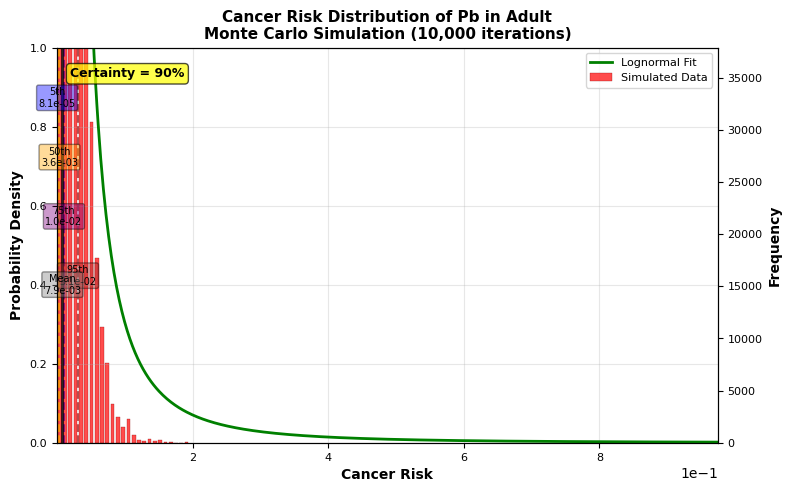


Pb - Adult Statistics:
Mean ILCR: 7.90e-03
5th percentile: 8.09e-05
95th percentile: 3.09e-02
----------------------------------------
Generating Excel analysis: carcinogenic_Monte_Carlo_Analysis.xlsx
Excel analysis completed! File saved as: carcinogenic_Monte_Carlo_Analysis.xlsx
Generated 6 sheets with comprehensive analysis.
Processing Pb - child...
Stored results for Pb_child: 420000 values
Graph saved: Pb_Child_CancerRisk.png


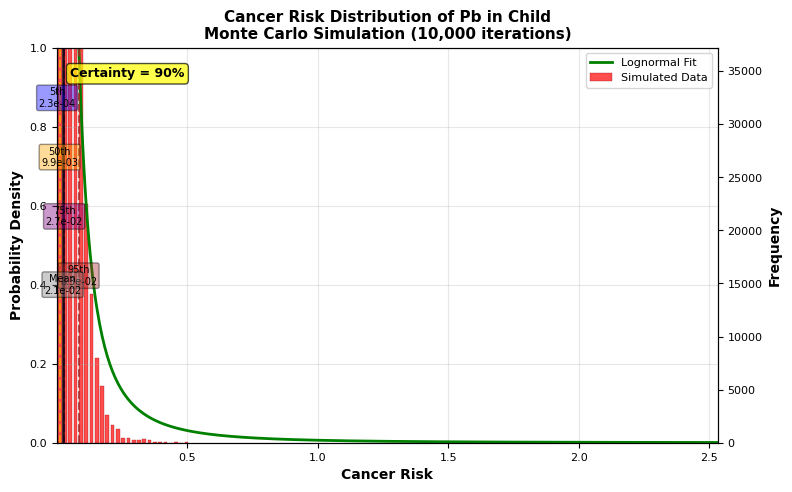


Pb - Child Statistics:
Mean ILCR: 2.13e-02
5th percentile: 2.25e-04
95th percentile: 8.27e-02
----------------------------------------
Generating Excel analysis: carcinogenic_Monte_Carlo_Analysis.xlsx
Excel analysis completed! File saved as: carcinogenic_Monte_Carlo_Analysis.xlsx
Generated 6 sheets with comprehensive analysis.
Processing Cd - adult...
Stored results for Cd_adult: 420000 values
Graph saved: Cd_Adult_CancerRisk.png


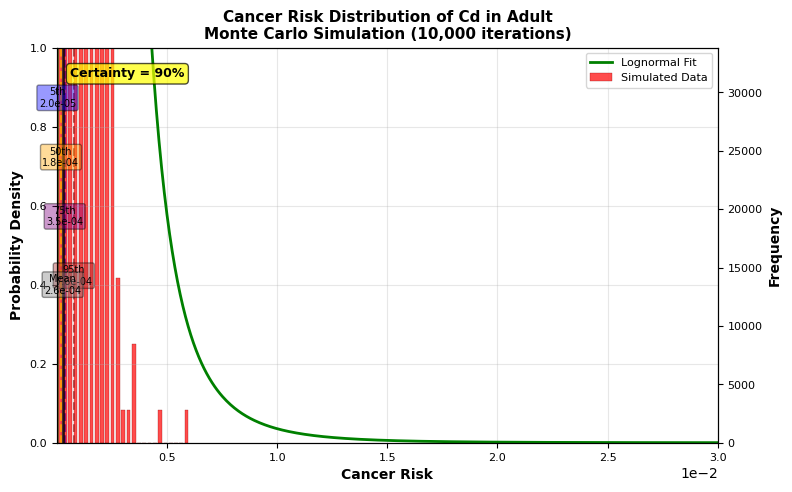


Cd - Adult Statistics:
Mean ILCR: 2.55e-04
5th percentile: 2.03e-05
95th percentile: 7.60e-04
----------------------------------------
Generating Excel analysis: carcinogenic_Monte_Carlo_Analysis.xlsx
Excel analysis completed! File saved as: carcinogenic_Monte_Carlo_Analysis.xlsx
Generated 6 sheets with comprehensive analysis.
Processing Cd - child...
Stored results for Cd_child: 420000 values
Graph saved: Cd_Child_CancerRisk.png


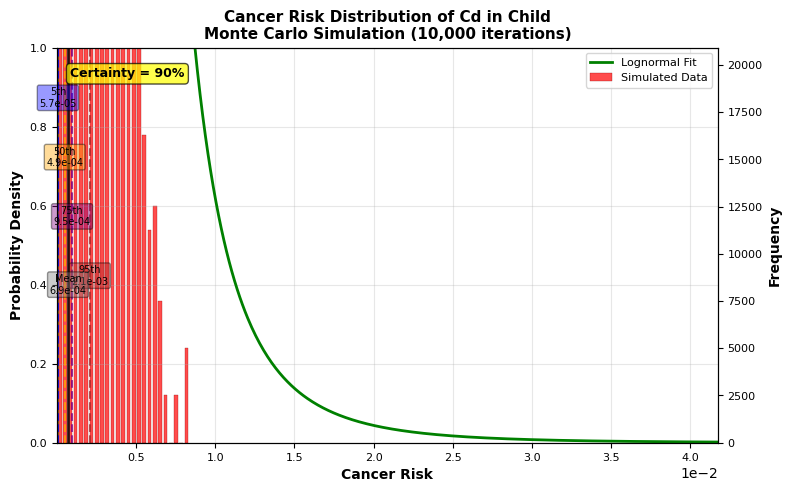


Cd - Child Statistics:
Mean ILCR: 6.93e-04
5th percentile: 5.69e-05
95th percentile: 2.07e-03
----------------------------------------
Generating Excel analysis: carcinogenic_Monte_Carlo_Analysis.xlsx
Excel analysis completed! File saved as: carcinogenic_Monte_Carlo_Analysis.xlsx
Generated 6 sheets with comprehensive analysis.
Processing Cr - adult...
Stored results for Cr_adult: 420000 values
Graph saved: Cr_Adult_CancerRisk.png


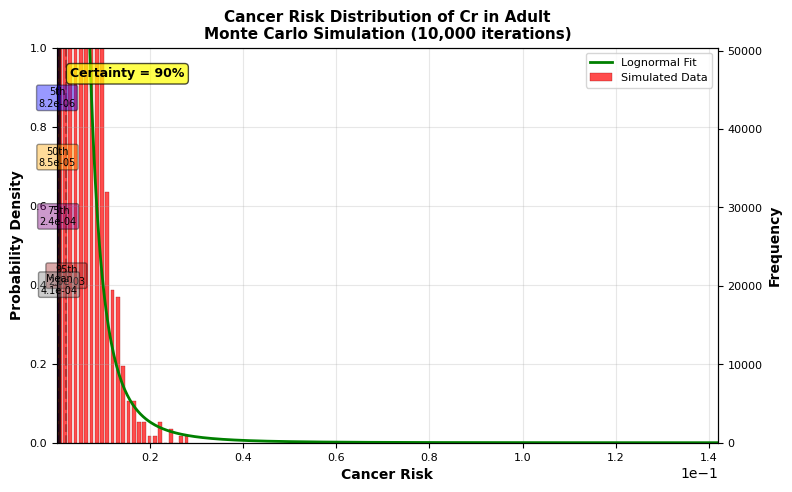


Cr - Adult Statistics:
Mean ILCR: 4.10e-04
5th percentile: 8.20e-06
95th percentile: 2.01e-03
----------------------------------------
Generating Excel analysis: carcinogenic_Monte_Carlo_Analysis.xlsx
Excel analysis completed! File saved as: carcinogenic_Monte_Carlo_Analysis.xlsx
Generated 6 sheets with comprehensive analysis.
Processing Cr - child...
Stored results for Cr_child: 420000 values
Graph saved: Cr_Child_CancerRisk.png


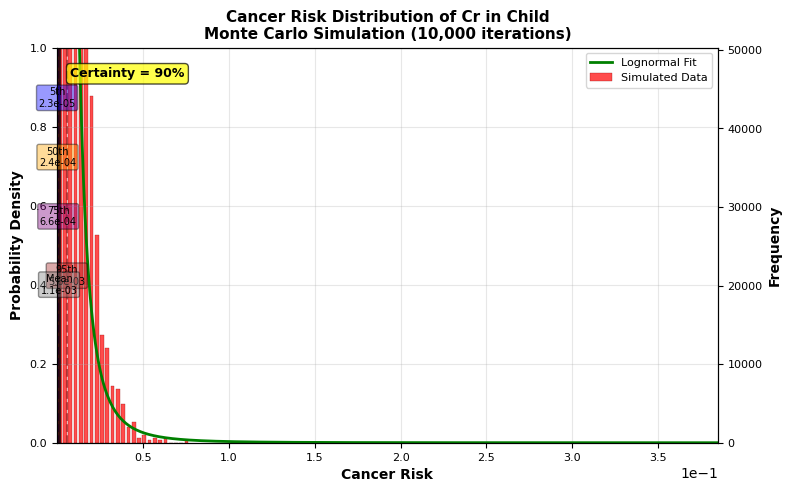


Cr - Child Statistics:
Mean ILCR: 1.13e-03
5th percentile: 2.30e-05
95th percentile: 5.63e-03
----------------------------------------
Generating Excel analysis: carcinogenic_Monte_Carlo_Analysis.xlsx
Excel analysis completed! File saved as: carcinogenic_Monte_Carlo_Analysis.xlsx
Generated 6 sheets with comprehensive analysis.
Processing Ni - adult...
Stored results for Ni_adult: 420000 values
Graph saved: Ni_Adult_CancerRisk.png


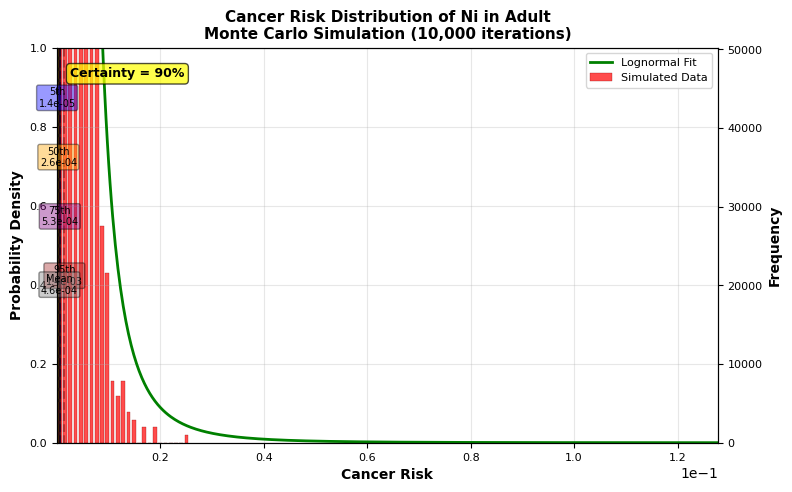


Ni - Adult Statistics:
Mean ILCR: 4.55e-04
5th percentile: 1.37e-05
95th percentile: 1.42e-03
----------------------------------------
Generating Excel analysis: carcinogenic_Monte_Carlo_Analysis.xlsx
Excel analysis completed! File saved as: carcinogenic_Monte_Carlo_Analysis.xlsx
Generated 6 sheets with comprehensive analysis.
Processing Ni - child...
Stored results for Ni_child: 420000 values
Graph saved: Ni_Child_CancerRisk.png


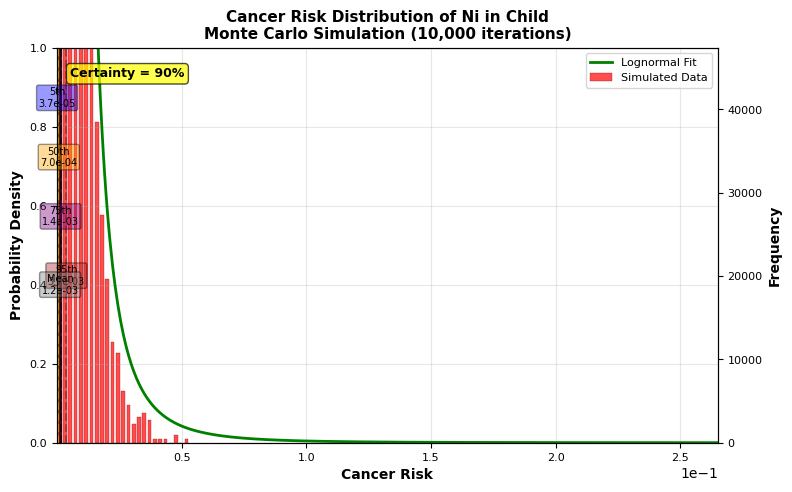


Ni - Child Statistics:
Mean ILCR: 1.23e-03
5th percentile: 3.70e-05
95th percentile: 3.74e-03
----------------------------------------
Generating Excel analysis: carcinogenic_Monte_Carlo_Analysis.xlsx
Excel analysis completed! File saved as: carcinogenic_Monte_Carlo_Analysis.xlsx
Generated 6 sheets with comprehensive analysis.
Processing As - adult...
Stored results for As_adult: 420000 values
Graph saved: As_Adult_CancerRisk.png


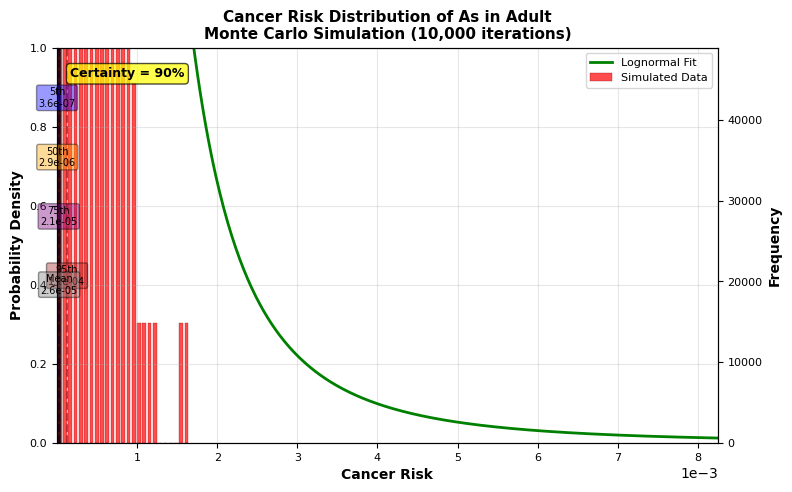


As - Adult Statistics:
Mean ILCR: 2.57e-05
5th percentile: 3.62e-07
95th percentile: 1.25e-04
----------------------------------------
Generating Excel analysis: carcinogenic_Monte_Carlo_Analysis.xlsx
Excel analysis completed! File saved as: carcinogenic_Monte_Carlo_Analysis.xlsx
Generated 6 sheets with comprehensive analysis.
Processing As - child...
Stored results for As_child: 420000 values
Graph saved: As_Child_CancerRisk.png


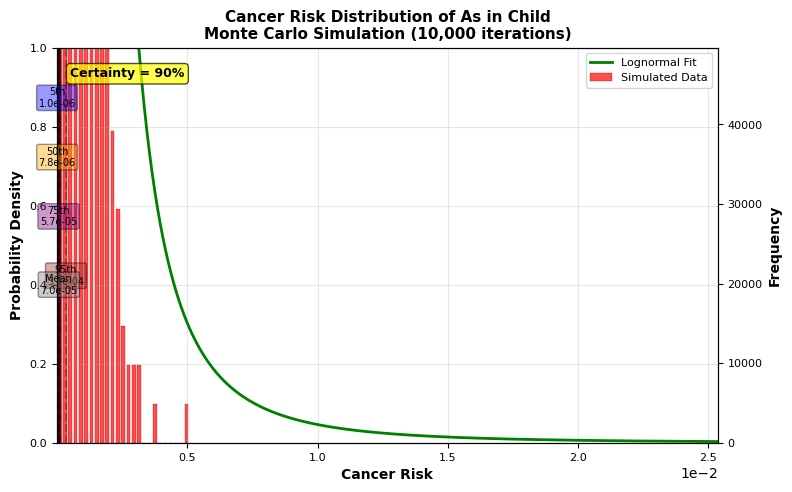


As - Child Statistics:
Mean ILCR: 7.01e-05
5th percentile: 1.01e-06
95th percentile: 3.42e-04
----------------------------------------
Generating Excel analysis: carcinogenic_Monte_Carlo_Analysis.xlsx
Excel analysis completed! File saved as: carcinogenic_Monte_Carlo_Analysis.xlsx
Generated 6 sheets with comprehensive analysis.

All visualizations completed!
Generating Excel analysis: carcinogenic_Monte_Carlo_Analysis.xlsx
Excel analysis completed! File saved as: carcinogenic_Monte_Carlo_Analysis.xlsx
Generated 6 sheets with comprehensive analysis.


'carcinogenic_Monte_Carlo_Analysis.xlsx'

In [13]:
print("Starting Optimized Monte Carlo Simulation...")
    
# Process each metal-age combination
metals = ['Pb', 'Cd', 'Cr', 'Ni', 'As']
age_groups = ['adult', 'child']

all_simulation_results = {}

for metal in metals:
    for age_group in age_groups:
        try:
            # Run simulation for this combination
            ilcr_results = run_optimized_monte_carlo(metal, age_group, n_iterations=10000)
            key = f"{metal}_{age_group}"
            all_simulation_results[key] = ilcr_results
            print(f"Stored results for {key}: {len(ilcr_results)} values")  # Confirmation

            # Skip if no valid results
            if len(ilcr_results[ilcr_results > 0]) == 0:
                print(f"Skipping {metal}_{age_group} - no positive values")
                continue
            
            # Create visualization
            save_path = f"{metal}_{age_group.capitalize()}_CancerRisk.png"
            create_optimized_visualization(ilcr_results, metal, age_group, save_path)
            if all_simulation_results:  # Check if we have results
                try:
                    generate_excel_analysis(all_simulation_results)
                except Exception as e:
                    print(f"Error generating Excel analysis: {e}")
            else:
                print("No simulation results to analyze!")
                
        except Exception as e:
                print(f"Error processing {metal}_{age_group}: {e}")
                continue
print("\nAll visualizations completed!")
generate_excel_analysis(all_results=all_simulation_results)